In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Support functions

In [79]:
# Function that resamples trajectory to have M evenly spaced points
def resample_trajectory(trajectory, M):
    N = len(trajectory)
    seg_len = path_length(trajectory) / M
    g = {0: trajectory[0]}
    i = 0
    k = 1
    alpha = 0.0
    beta = seg_len
    
    while (i < N) and (k < M):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        d = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        
        while (beta <= alpha + d) and (k < M):
            xk = x0 + (beta - alpha) * (x1 - x0) / d
            yk = y0 + (beta - alpha) * (y1 - y0) / d
            g[k] = (xk, yk)
            k += 1
            beta += seg_len
            
        alpha += d
        i += 1
        
    return g
    
# Function that computes the total length of the trajectory
def path_length(trajectory):
    N = len(trajectory)
    length = 0.0
    for i in range(0,N):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        length += ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return length

# Function that computes the Fourier Descriptor Transform
def fourier_descriptor_transform(g):
    N = len(g)
    z = np.array([complex(x, y) for x, y in g.values()])
    Z = np.fft.fft(z) / N
    return Z

# Function that computes the Inverse Fourier Descriptor Transform
def inverse_fourier_descriptor_transform(Z):
    N = len(Z)
    z = np.fft.ifft(Z * N)
    g_reconstructed = {m: (z[m].real, z[m].imag) for m in range(N)}
    return g_reconstructed

def get_descriptors(filepath, M=100):
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    Z = fourier_descriptor_transform(g)
    return Z

In [3]:
def get_descriptors(filepath, M=100):
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    Z = fourier_descriptor_transform(g)
    return Z

In [4]:
def plot_spiral(filepath):
    df_spiral = pd.read_csv(filepath)
    df_spiral.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df_spiral['x'] = df_spiral['x'] - df_spiral['x'].iloc[0]
    df_spiral['y'] = df_spiral['y'] - df_spiral['y'].iloc[0]

    spiral_name = filepath.split('/')[-1]
    spiral_name = spiral_name.split('.')[0]
    _, fig = plt.subplots(figsize=(12,6))
    fig.set_title(f'Original Spiral Drawing of {spiral_name}')
    fig.plot(df_spiral['x'], df_spiral['y'])
    fig.axis('equal')
    plt.show()

### Transforming drawings to Fourier descriptors

**Single file**

In [5]:
directory = "drawings/normal/"
filepath = directory + "stisnjena3.csv"
df = pd.read_csv(filepath)
df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
df['x'] = df['x'] - df['x'].iloc[0]
df['y'] = df['y'] - df['y'].iloc[0]

M = 100 # Number of points to resample to
g = resample_trajectory(list(zip(df['x'], df['y'])), M)

In [6]:
Z = fourier_descriptor_transform(g)
g_reconst = inverse_fourier_descriptor_transform(Z)

In [7]:
list(g_reconst.values())[:][0]

(np.float64(-3.637978807091713e-14), np.float64(-3.637978807091713e-14))

In [8]:
g_rec_df = pd.DataFrame.from_dict(g_reconst, orient='index', columns=['x', 'y'])
g_rec_df.to_csv(directory + "stisn_rec_" + str(M) + '_test' + '.csv', index=False)

**Multiple files**

In [9]:
M = 100

directory = "drawings/long/"
# filenames = ["spirala", "stisnjena", "nazobcena", "flat"]
filenames = ["l_spiral", "l_spiky", "l_tight", "l_flat"]

filepaths = [directory + name + f"{i}.csv" for name in filenames for i in range(1,6)]

In [10]:
df_general = pd.DataFrame()

for filepath in filepaths:
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    
    Z = fourier_descriptor_transform(g)
    g_reconst = inverse_fourier_descriptor_transform(Z)

    g_rec_df = pd.DataFrame.from_dict(g_reconst, orient='index', columns=['x', 'y'])
    g_rec_df['dft_real'] = Z.real
    g_rec_df['dft_imag'] = Z.imag
    g_rec_df['original_file'] = os.path.basename(filepath)
    df_general = pd.concat([df_general, g_rec_df], ignore_index=True)

In [11]:
df_general.to_csv(directory + "l_all_dft_reconstructed_" + str(M) + '.csv', index=False)

### PCA Analysis

**Option 1 - stacking Re and Im parts**

In [57]:
filepath_pca = "drawings/long/l_all_dft_reconstructed_500.csv"
df_pca = pd.read_csv(filepath_pca)

df_pca.head()

,x,y,dft_real,dft_imag,original_file
0,-1.455192e-14,-7.275958e-15,4.570887,8.306482,l_spiral1.csv
1,-2.423710e+00,4.237104e-01,1.229390,6.105482,l_spiral1.csv
2,-3.784220e+00,2.000000e+00,0.237325,3.992173,l_spiral1.csv
3,-4.000000e+00,4.383437e+00,-0.803381,3.364258,l_spiral1.csv
4,-4.000000e+00,6.982654e+00,-1.154130,3.325837,l_spiral1.csv


In [58]:
# Combining vectors per file and stacking the real and imaginary parts
grouped = df_pca.groupby('original_file')

features_pca = []
features_names = []

for name, group in grouped:
    real_parts = group['dft_real'].values
    imag_parts = group['dft_imag'].values
    feature_vector = np.concatenate([real_parts, imag_parts])
    features_pca.append(feature_vector)
    features_names.append(name)

features_pca = np.array(features_pca)
print("features_pca shape: " + str(features_pca.shape))

features_pca shape: (20, 1000)


In [59]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_pca)
print("X_pca shape: " + str(X_pca.shape))

X_pca shape: (20, 2)


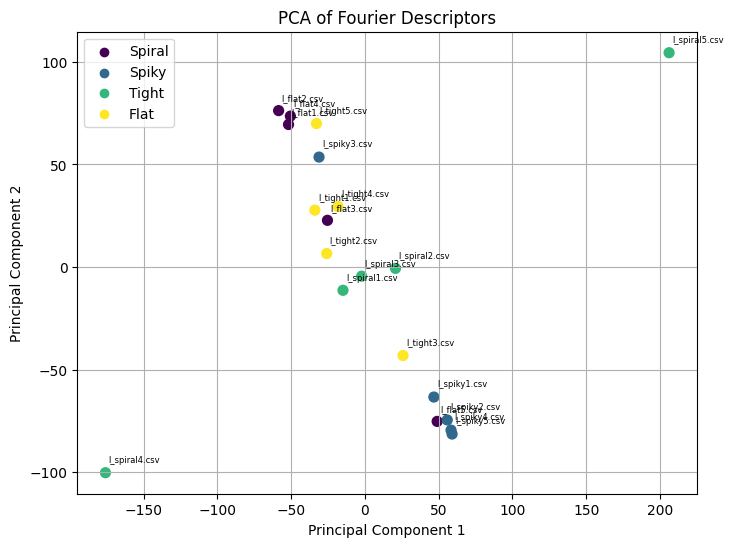

In [60]:
labels = 5*[0] + 5*[1] + 5*[2] + 5*[3]
labels_dic = {0: 'Spiral', 1: 'Spiky', 2: 'Tight', 3: 'Flat'}

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=50)
plt.title('PCA of Fourier Descriptors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Point annotation
for i, name in enumerate(features_names):
    plt.annotate(name, (X_pca[i,0]+2, X_pca[i,1]+5), fontsize=6)

for i in np.unique(labels):
    plt.scatter([], [], color=scatter.cmap(scatter.norm(i)), label=f"{labels_dic[i]}")
plt.legend()
plt.grid()
plt.show()

In [61]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    #index=feature_names  # list of your original feature names
)

print("Explained variance ratio:", pca.explained_variance_ratio_)
display(loadings.head(10))

Explained variance ratio: [0.40496629 0.30355877]


,PC1,PC2
0,-0.177593,0.026446
1,-0.163895,0.160472
2,-0.251935,0.393320
3,0.201872,-0.404123
4,0.012212,0.001373
5,0.065578,-0.092618
6,0.063468,-0.091137
7,0.036513,-0.045827
8,0.008173,0.013011
9,-0.006354,0.036166


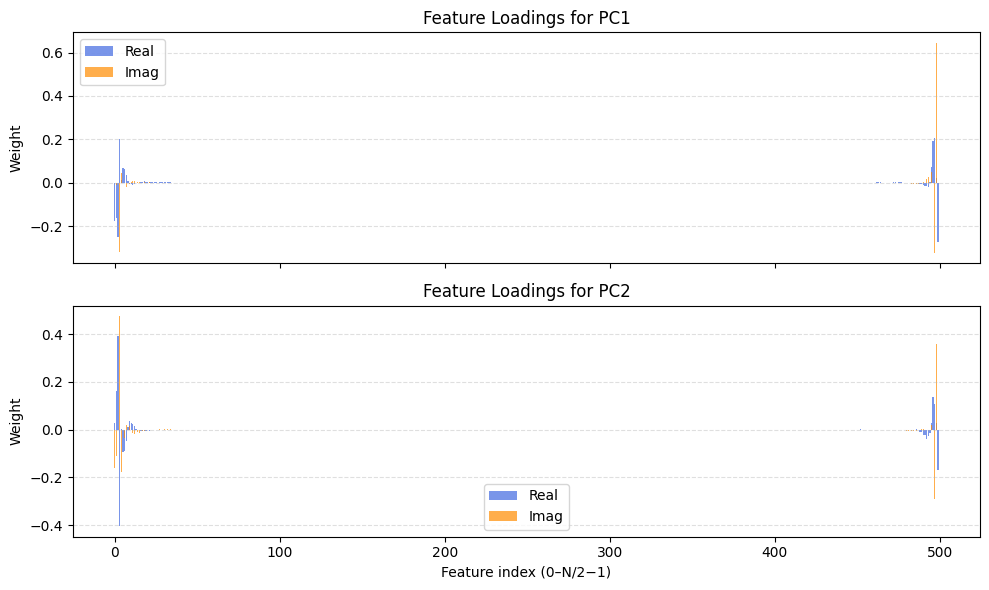

In [62]:
n_components = loadings.shape[1]
n_features = loadings.shape[0]
half = n_features // 2  # split point between real and imaginary

x = np.arange(half)  # x-axis for both halves

fig, axes = plt.subplots(n_components, 1, figsize=(10, 3 * n_components), sharex=True)

if n_components == 1:
    axes = [axes]  # ensure iterable

for i, ax in enumerate(axes):
    pc_name = loadings.columns[i]
    
    # Split loadings
    real_load = loadings.iloc[:half, i]
    imag_load = loadings.iloc[half:, i]
    
    # Plot both halves
    ax.bar(x, real_load, color='royalblue', alpha=0.7, label='Real')
    ax.bar(x, imag_load, color='darkorange', alpha=0.7, label='Imag', width=0.4)
    
    ax.set_title(f"Feature Loadings for {pc_name}")
    ax.set_ylabel("Weight")
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    ax.legend()

axes[-1].set_xlabel("Feature index (0–N/2−1)")
plt.tight_layout()
plt.show()

Plot spiral of interest:

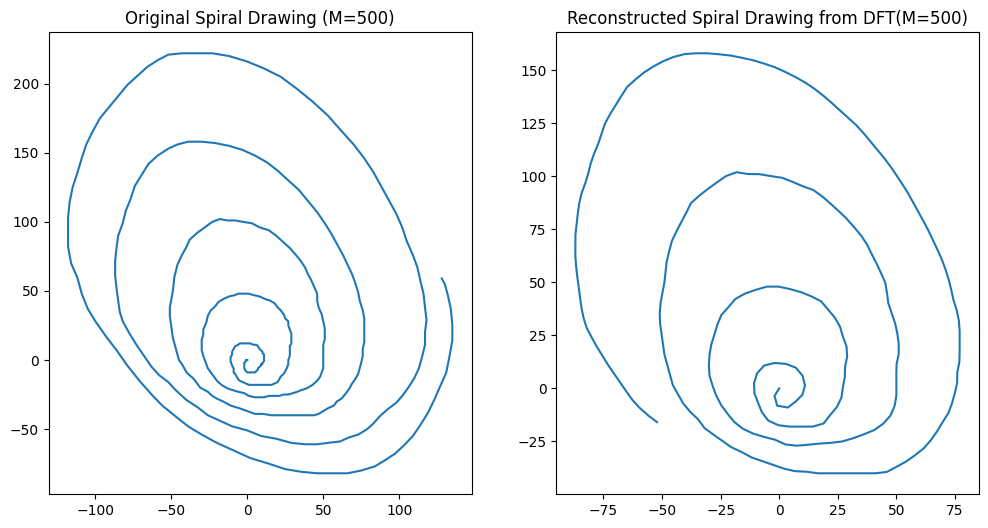

In [63]:
directory = "drawings/long/"
spiral = "l_tight2.csv"
spiral_path = directory + spiral

df_spiral = pd.read_csv(spiral_path)
df_spiral.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
df_spiral['x'] = df_spiral['x'] - df_spiral['x'].iloc[0]
df_spiral['y'] = df_spiral['y'] - df_spiral['y'].iloc[0]

num_of_desc = features_pca.shape[1] // 2

spiral_idx = features_names.index(spiral)
spiralZ = features_pca[spiral_idx][:num_of_desc] + 1j * features_pca[spiral_idx][num_of_desc:]
g_spiral_reconst = inverse_fourier_descriptor_transform(spiralZ)

ax, fig = plt.subplots(1, 2, figsize=(12,6))
fig[0].set_title(f'Original Spiral Drawing (M={num_of_desc})')
fig[0].plot(df_spiral['x'], df_spiral['y'])
fig[1].set_title(f'Reconstructed Spiral Drawing from DFT(M={num_of_desc})')
fig[1].plot(*zip(*g_spiral_reconst.values()))
plt.show()

**Option 2 - rotation invariant descriptors**

In [19]:
df_ri = pd.read_csv(filepath_pca)
df_ri.head()

,x,y,dft_real,dft_imag,original_file
0,-1.455192e-14,-7.275958e-15,4.570887,8.306482,l_spiral1.csv
1,-2.423710e+00,4.237104e-01,1.229390,6.105482,l_spiral1.csv
2,-3.784220e+00,2.000000e+00,0.237325,3.992173,l_spiral1.csv
3,-4.000000e+00,4.383437e+00,-0.803381,3.364258,l_spiral1.csv
4,-4.000000e+00,6.982654e+00,-1.154130,3.325837,l_spiral1.csv


In [20]:
# Combining vectors per file and stacking the real and imaginary parts
grouped = df_ri.groupby('original_file')

features_ri = []

for _, group in grouped:
    # Normalize for rotation invariance
    Z = group['dft_real'].values + 1j * group['dft_imag'].values

    # Find first significant harmonic (nonzero magnitude)
    k0 = np.argmax(np.abs(Z[1:]) > 1e-8) + 1  # skip DC term Z[0]
    phase = np.angle(Z[k0])

    Zi = Z * np.exp(-1j * phase)

    
    real_parts = Zi.real
    imag_parts = Zi.imag
    feature_vector = np.concatenate([real_parts, imag_parts])
    features_ri.append(feature_vector)

features_ri = np.array(features_ri)
print("features_ri shape: " + str(features_ri.shape))

features_ri shape: (20, 1000)


In [21]:
pca_ri = PCA(n_components=2)
X_ri = pca_ri.fit_transform(features_ri)
print("X_ri shape: " + str(X_ri.shape))

X_ri shape: (20, 2)


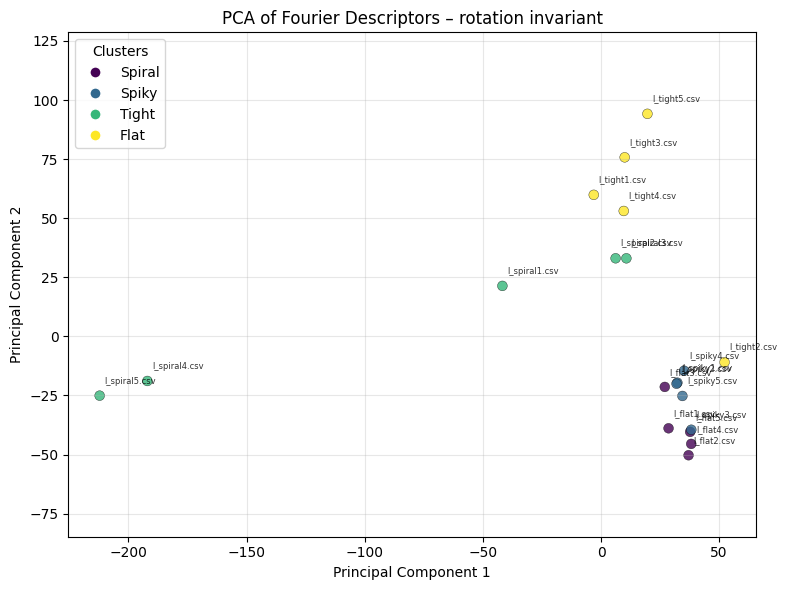

In [22]:
plt.figure(figsize=(8, 6))

# Main scatter plot
scatter = plt.scatter(
    X_ri[:, 0], X_ri[:, 1],
    c=labels, cmap='viridis', s=50, alpha=0.8, edgecolors='k', linewidths=0.3
)

plt.title('PCA of Fourier Descriptors – rotation invariant')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Optional: annotate each point (only if there aren’t too many)
for i, name in enumerate(features_names):
    plt.annotate(
        name,
        (X_ri[i, 0] + 2, X_ri[i, 1] + 5),
        fontsize=6,
        alpha=0.8
    )

# Legend based on cluster colors
handles = [
    plt.Line2D(
        [], [], marker='o', color='w',
        markerfacecolor=scatter.cmap(scatter.norm(i)),
        label=labels_dic[i], markersize=8
    )
    for i in np.unique(labels)
]
plt.legend(handles=handles, title="Clusters", frameon=True)
plt.axis('equal')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
loadings_ri = pd.DataFrame(
    pca_ri.components_.T,
    columns=[f"PC{i+1}" for i in range(pca_ri.n_components_)],
    #index=feature_names  # list of your original feature names
)

print("Explained variance ratio:", pca_ri.explained_variance_ratio_)
display(loadings_ri.head(10))

Explained variance ratio: [0.54942258 0.20099921]


,PC1,PC2
0,-0.108434,-0.143124
1,0.002961,-0.065341
2,0.045837,-0.044859
3,-0.293512,0.580664
4,0.020193,-0.515265
5,-0.032209,0.106739
6,-0.033616,0.082654
7,-0.013112,-0.020430
8,0.010003,-0.017970
9,0.016191,-0.002437


### tSNE Analysis

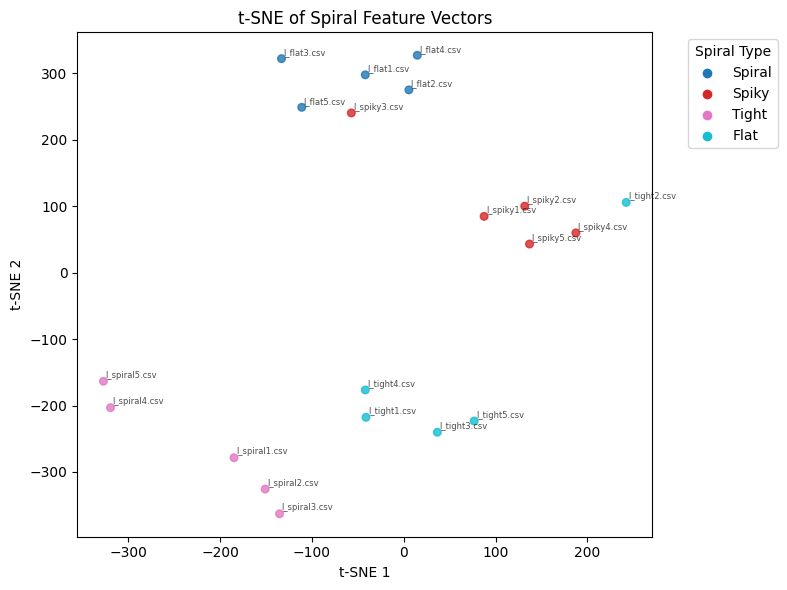

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# --- Compute t-SNE ---
tsne = TSNE(
    n_components=2,       
    perplexity=4,          # small if you have few spirals
    learning_rate=200,    
    random_state=42
)
X_embedded = tsne.fit_transform(features_ri)

# --- Visualize ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_embedded[:, 0], 
    X_embedded[:, 1], 
    c=labels,            # color points by cluster label
    cmap='tab10',        # consistent and qualitative colormap
    s=30, 
    alpha=0.8
)

for i, name in enumerate(features_names):
    plt.annotate(
        name,
        (X_embedded[i, 0] + 2, X_embedded[i, 1] + 5),
        fontsize=6,
        alpha=0.7
    )

# --- Legend ---
for i in np.unique(labels):
    plt.scatter([], [], color=scatter.cmap(scatter.norm(i)), label=labels_dic[i])
plt.legend(title="Spiral Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("t-SNE of Spiral Feature Vectors")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

In [25]:
Z

array([-4.97263744e+00-5.64106217e+01j,  3.00642425e+01+5.60558304e+00j,
        3.16549104e+01+2.43987751e+01j, -1.56341011e+01+6.63693562e+01j,
       -5.40124113e+01-3.65400661e+01j,  7.65990155e+00+1.88062521e+01j,
        5.57649074e+00-2.03316727e+01j, -1.35260621e+01-9.21707378e+00j,
       -8.72377486e+00+6.19256453e+00j,  2.66812039e+00+6.13358001e+00j,
        5.84542411e+00+6.54537326e-01j,  6.17290336e+00-3.36919701e+00j,
        1.78867841e+00-5.17230615e+00j,  2.84620778e-01-5.47835359e+00j,
       -1.28241935e+00-3.28551193e+00j, -1.16560438e+00-1.60824961e+00j,
       -1.34599292e+00-1.80391013e+00j, -1.94237957e+00-9.70014506e-01j,
       -1.04816804e+00+2.55182368e-01j, -5.93992631e-01-1.25683741e-01j,
       -6.40143318e-01+1.35302737e-01j, -6.29300350e-01+5.12077628e-01j,
        1.44585091e-01+9.20769490e-01j,  2.40272295e-01+4.51981250e-01j,
        1.81471344e-02+6.40552846e-01j,  1.28221252e-01+5.55627153e-01j,
        1.08658718e-01+6.29646082e-01j,  2.53379522

### Interactive plot

In [26]:
from ipywidgets import interact, FloatSlider

# --- Load spiral and its Fourier descriptors ---
spiral = "l_spiky2.csv"
df = grouped.get_group(spiral)
x_real = df['x'].values
y_real = df['y'].values

# Reconstruct complex Fourier descriptors
Z = df['dft_real'].values + 1j * df['dft_imag'].values
N = len(Z)

# Choose which two descriptors to manipulate
idx1, idx2 = 1,2

# Get magnitude of descriptors for slider range
mag1, mag2 = np.abs(Z[idx1]), np.abs(Z[idx2])

def update_descriptor(re1=0.0, im1=0.0, re2=0.0, im2=0.0):
    Z_mod = Z.copy()
    
    # Apply slider values
    Z_mod[idx1] = re1 + 1j * im1
    Z_mod[idx2] = re2 + 1j * im2
    
    # Reconstruct
    recon = inverse_fourier_descriptor_transform(Z_mod)
    
    plt.figure(figsize=(6,6))
    plt.plot(x_real, y_real, color='gray', alpha=0.3, lw=2, label='Original')
    plt.plot([t[0] for t in recon.values()], [t[1] for t in recon.values()], color='blue', lw=2, label='Reconstruction')
    plt.axis('equal')
    plt.legend()
    plt.show()

# --- Sliders with ranges proportional to descriptor magnitudes ---
interact(
    update_descriptor,
    re1=FloatSlider(min=-2*mag1, max=2*mag1, step=mag1/50, value=Z[idx1].real, description=f'Re(Z{idx1})'),
    im1=FloatSlider(min=-2*mag1, max=2*mag1, step=mag1/50, value=Z[idx1].imag, description=f'Im(Z{idx1})'),
    re2=FloatSlider(min=-2*mag2, max=2*mag2, step=mag2/50, value=Z[idx2].real, description=f'Re(Z{idx2})'),
    im2=FloatSlider(min=-2*mag2, max=2*mag2, step=mag2/50, value=Z[idx2].imag, description=f'Im(Z{idx2})')
)

interactive(children=(FloatSlider(value=-23.538082816495752, description='Re(Z1)', max=48.01780717355447, min=…

<function __main__.update_descriptor(re1=0.0, im1=0.0, re2=0.0, im2=0.0)>

In [27]:
# --- Load spiral and its Fourier descriptors ---
spiral = "l_spiky3.csv"
df = grouped.get_group(spiral)
x_real = df['x'].values
y_real = df['y'].values

# Reconstruct complex Fourier descriptors
Z = df['dft_real'].values + 1j * df['dft_imag'].values
N = len(Z)

PCA1_w = loadings_ri.iloc[:,0].values
PCA2_w = loadings_ri.iloc[:,1].values

def update_descriptor(c1=0.0, c2=0.0):
    Z_mod = Z.copy()
    
    # Apply slider values
    Z_mod += c1 * PCA1_w[:N] + c1 * PCA1_w[N:] * 1j + c2 * PCA2_w[:N] + c2 * PCA2_w[N:] * 1j
    
    # Reconstruct
    recon = inverse_fourier_descriptor_transform(Z_mod)
    
    plt.figure(figsize=(6,6))
    plt.plot(x_real, y_real, color='gray', alpha=0.3, lw=2, label='Original')
    plt.plot([t[0] for t in recon.values()], [t[1] for t in recon.values()], color='blue', lw=2, label='Reconstruction')
    plt.axis('equal')
    plt.legend()
    plt.show()

# --- Sliders with ranges proportional to descriptor magnitudes ---
interact(
    update_descriptor,
    c1=FloatSlider(min=-20, max=20, step=1/5, value=0, description=f'PCA1'),
    c2=FloatSlider(min=-20, max=20, step=1/5, value=0, description=f'PCA2'),
)

interactive(children=(FloatSlider(value=0.0, description='PCA1', max=20.0, min=-20.0, step=0.2), FloatSlider(v…

<function __main__.update_descriptor(c1=0.0, c2=0.0)>

### Archimedes spiral

In [28]:
def archimedas_spiral(theta_range, a0, granularity=500):
    theta = np.linspace(theta_range[0], theta_range[1], granularity)
    arch_x = a0*theta*np.cos(theta)
    arch_y = a0*theta*np.sin(theta)
    
    return (arch_x,arch_y)

def archimedas_descriptor(theta_range, a0, granularity=500):
    arch = archimedas_spiral(theta_range, a0, granularity)
    
    arch_traj = resample_trajectory([(x,y) for x,y in zip(arch[0],arch[1])],M)
    Z_archimedes = fourier_descriptor_transform(arch_traj)
    
    return Z_archimedes

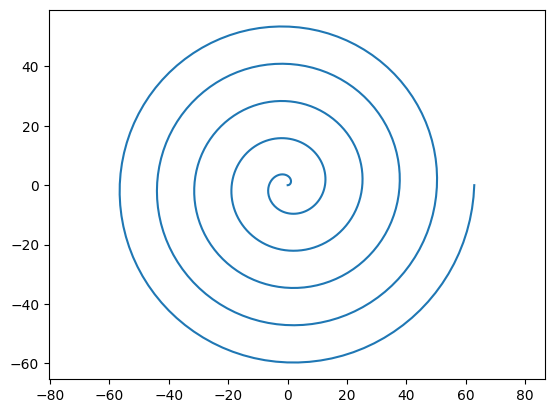

In [29]:
theta_range = [0,10*np.pi]
a0 = 2

arch = archimedas_spiral(theta_range, a0)
plt.plot(arch[0],arch[1])
plt.axis('equal')
plt.show()

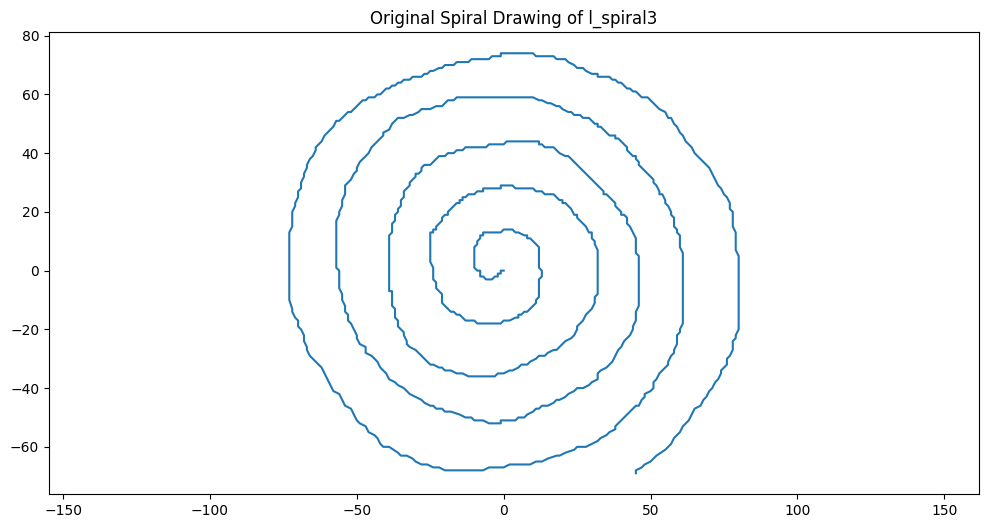

In [30]:
file_path = "drawings/long/l_spiral3.csv"
plot_spiral(file_path)

**Tampered Archimedes**

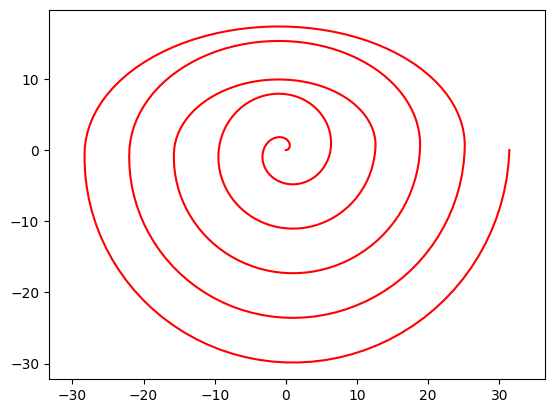

In [31]:
theta_range = [0,10*np.pi]
a0 = [1]*500
b0 = [1]*200 + [0.7]*50 + [1]*50  + [0.75]*50 + [1]*50 + [0.65]*50 + [1]*50

theta = np.linspace(theta_range[0], theta_range[1], 500)
arch_x = a0*theta*np.cos(theta)
arch_y = b0*theta*np.sin(theta)

plt.plot(arch_x, arch_y, color='red')
plt.axis('equal')
plt.show()

### Fourier coeficients

In [32]:
def plot_coeficients(Zs, names=None, rot_inv=True):
    N = len(Zs[0])
    num_comp = len(Zs)
    
    x = np.arange(N)
    _, axes = plt.subplots(num_comp, 1, figsize=(12, 5 * n_components), sharex=True)
    if num_comp == 1: axes = [axes]
    
    vectors = []
    
    for i, ax in enumerate(axes):
        
        Z_real = Zs[i].real
        Z_imag = Zs[i].imag
        
        if rot_inv:
            Z = Z_real + 1j * Z_imag

            k0 = np.argmax(np.abs(Z[1:]) > 1e-8) + 1  # skip DC term Z[0]
            phase = np.angle(Z[k0])

            Zi = Z * np.exp(-1j * phase)
            Z_real = Zi.real
            Z_imag = Zi.imag
        
        temp = np.concatenate((Z_real,Z_imag))
        
        vectors.append(temp)
        
        ax.bar(x, Z_real, color='royalblue', alpha=0.7, label='Real')
        ax.bar(x, Z_imag, color='darkorange', alpha=0.7, label='Imag', width=0.4)
        
        if names is not None:
            ax.set_title(f"Fourier coeficients for {names[i]}")
        else:
            ax.set_title(f"Fourier coeficients")
        ax.set_ylabel("Weight")
        ax.grid(True, axis='y', linestyle='--', alpha=0.4)
        ax.legend()

    dist = np.sqrt(np.sum([(x-y)**2 for x,y in zip(vectors[0],vectors[-1])]))
    print(dist)
    
    
    axes[-1].set_xlabel("Feature index")
    plt.tight_layout()
    plt.show()

103.0402620050665


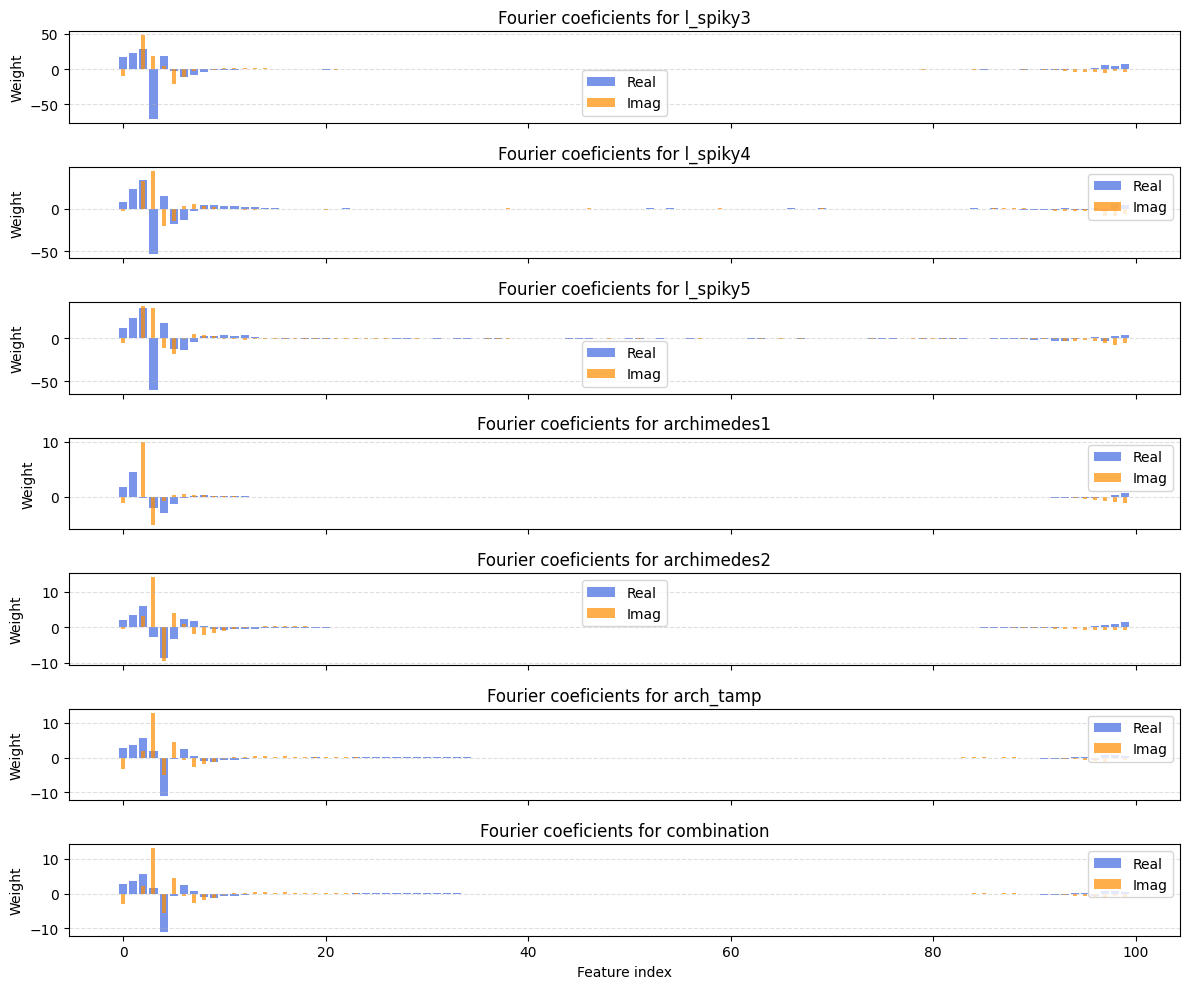

In [33]:
file_path1 = "drawings/long/l_spiky3.csv"
file_path2 = "drawings/long/l_spiky4.csv"
file_path3 = "drawings/long/l_spiky5.csv"
names = [file_path1.split('/')[-1].split('.')[0], file_path2.split('/')[-1].split('.')[0], file_path3.split('/')[-1].split('.')[0]] + ["archimedes1", "archimedes2", "arch_tamp","combination"]
M = 100

Z_spiral1 = get_descriptors(file_path1, M=M)
Z_spiral2 = get_descriptors(file_path2, M=M)
Z_spiral3 = get_descriptors(file_path3, M=M)

Z_arch1 = archimedas_descriptor([0,6*np.pi], 1)
Z_arch2 = archimedas_descriptor([0,8*np.pi], 1)
Z_arch3 = archimedas_descriptor([0,10*np.pi], 1)

Z_tamp = fourier_descriptor_transform(resample_trajectory(list(zip(arch_x, arch_y)), M))

Z_spiral4 = 1*Z_arch3 + (Z_tamp-Z_arch3)*0.9

plot_coeficients([Z_spiral1, Z_spiral2, Z_spiral3, Z_arch1,Z_arch3, Z_tamp, Z_spiral4], names=names, rot_inv=True)

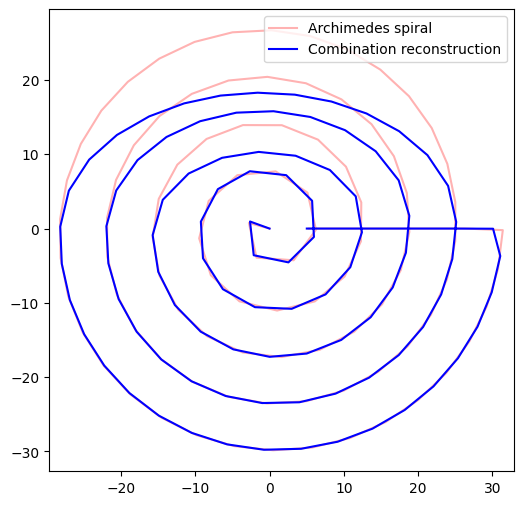

In [34]:
g_recon = inverse_fourier_descriptor_transform(Z_spiral4)
g_recon_org = inverse_fourier_descriptor_transform(Z_arch3)

plt.figure(figsize=(6,6))
# plt.plot(arch_x, arch_y, color='red', alpha=0.3, label='Archimedes with modulation')
plt.plot(*zip(*g_recon_org.values()), color='red', alpha=0.3, label='Archimedes spiral')
plt.plot(*zip(*g_recon.values()), color='blue', label='Combination reconstruction')
plt.axis('equal')
plt.legend()
plt.show()

In [35]:
from scipy.spatial.distance import cdist

def plot_distances(df, rotation_invariant=True):
    matrix = []
    names = []

    for name, group in df.groupby("original_file"):
        
        if rotation_invariant:
            Z = group['dft_real'].values + 1j * group['dft_imag'].values

            k0 = np.argmax(np.abs(Z[1:]) > 1e-8) + 1  # skip DC term Z[0]
            phase = np.angle(Z[k0])

            Zi = Z * np.exp(-1j * phase)
            real = Zi.real
            imag = Zi.imag
        else:        
            real = group["dft_real"].to_numpy()
            imag = group["dft_imag"].to_numpy()
        
        descriptor = np.concatenate([real, imag])
        matrix.append(descriptor)
        names.append(name)

    matrix = np.array(matrix)
    # --- Compute distances ---
    dist_matrix = cdist(matrix, matrix, metric="euclidean")

    # --- Plot heatmap ---
    _, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(dist_matrix, cmap="viridis", interpolation="nearest")

    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_yticklabels(names)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Euclidean distance")
    ax.set_title("Pairwise Euclidean Distance between Fourier Descriptor Vectors")
    
    step_x = len(names) / 4
    step_y = len(names) / 4
    for i in range(1, 4):
        ax.axvline(i * step_x - 0.5, color='white', linewidth=1.2)
        ax.axhline(i * step_y - 0.5, color='white', linewidth=1.2)

    plt.tight_layout()
    plt.show()

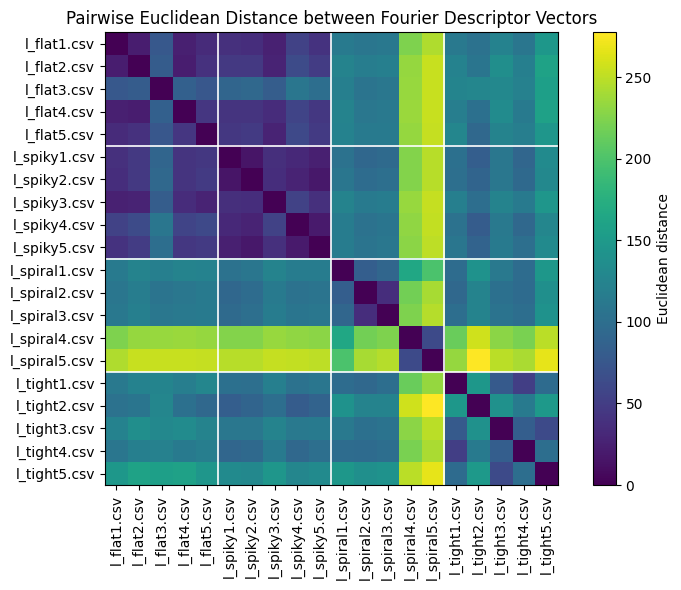

In [36]:
df = pd.read_csv("drawings/long/l_all_dft_reconstructed_100.csv")
plot_distances(df, rotation_invariant=True)

In [37]:
grouped = df.groupby("original_file")

l_spiral4_r = None
l_spiral4_i = None
l_spiral5_r = None
l_spiral5_i = None

for name, group in grouped:
    if name == "l_spiky5.csv":
        Z = group['dft_real'].values + 1j * group['dft_imag'].values

        k0 = np.argmax(np.abs(Z[1:]) > 1e-8) + 1  # skip DC term Z[0]
        phase = np.angle(Z[k0])

        Zi = Z * np.exp(-1j * phase)
        l_spiral4_r = Zi.real
        l_spiral4_i = Zi.imag
    if name == "l_spiral3.csv":
        Z = group['dft_real'].values + 1j * group['dft_imag'].values

        k0 = np.argmax(np.abs(Z[1:]) > 1e-8) + 1  # skip DC term Z[0]
        phase = np.angle(Z[k0])

        Zi = Z * np.exp(-1j * phase)
        l_spiral5_r = Zi.real
        l_spiral5_i = Zi.imag

dist_r = np.sqrt(np.sum([(r1-r2)**2 for r1,r2 in zip(l_spiral4_r, l_spiral5_r)]))
dist_i = np.sqrt(np.sum([(i1-i2)**2 for i1,i2 in zip(l_spiral4_i, l_spiral5_i)]))

print(dist_r + dist_i)

155.16136679095436


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_spirals_with_coeffs(filepaths, archimedes_params, M=100, rot_inv=True):
    """
    Plots each spiral (from file or Archimedean params) with its Fourier coefficients.

    filepaths: list of strings
    archimedes_params: list of tuples [(t_range, a), ...] e.g. [([0, 6*np.pi], 1)]
    M: number of resampled points for descriptors
    rot_inv: whether to make coefficients rotation invariant
    """

    all_names = []
    all_descriptors = []
    spirals_xy = []

    # --- Load spirals from files ---
    for fp in filepaths:
        name = fp.split('/')[-1].split('.')[0]
        df = pd.read_csv(fp)
        df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
        df['x'] = df['x'] - df['x'].iloc[0]
        df['y'] = df['y'] - df['y'].iloc[0]

        spirals_xy.append((df['x'].values, df['y'].values))
        all_names.append(name)

        Z = get_descriptors(fp, M=M)
        all_descriptors.append(Z)

    # --- Add Archimedean spirals ---
    for i, (t_range, a) in enumerate(archimedes_params):
        name = f"archimedes{i+1}"
        all_names.append(name)

        Z = archimedas_descriptor(t_range, a)
        all_descriptors.append(Z)

        # generate spiral coordinates
        t = np.linspace(t_range[0], t_range[1], M)
        x = a * t * np.cos(t)
        y = a * t * np.sin(t)
        spirals_xy.append((x, y))

    # --- Setup figure ---
    n = len(all_descriptors)
    fig, axes = plt.subplots(n, 2, figsize=(10, 3 * n), gridspec_kw={'width_ratios': [1, 7]})

    if n == 1:
        axes = np.array([axes])  # handle single-row case

    for i, (Z, name, (x, y)) in enumerate(zip(all_descriptors, all_names, spirals_xy)):
        ax_spiral, ax_bar = axes[i]

        # --- Spiral plot ---
        ax_spiral.plot(x, y, color='black')
        ax_spiral.axis('equal')
        ax_spiral.axis('off')
        ax_spiral.set_title(name)

        # --- Fourier coefficient bar plot ---
        re = np.real(Z)
        im = np.imag(Z)
        if rot_inv:
            re -= re.mean()
            im -= im.mean()

        idx = np.arange(len(Z))
        width = 0.35
        ax_bar.bar(idx - width/2, re, width, color='royalblue', alpha=0.7, label='Real')
        ax_bar.bar(idx + width/2, im, width, color='orange', alpha=0.7, label='Imag')

        ax_bar.set_title(f'Fourier coefficients for {name}')
        ax_bar.set_ylabel('Weight')
        ax_bar.legend()

    plt.tight_layout()
    plt.show()


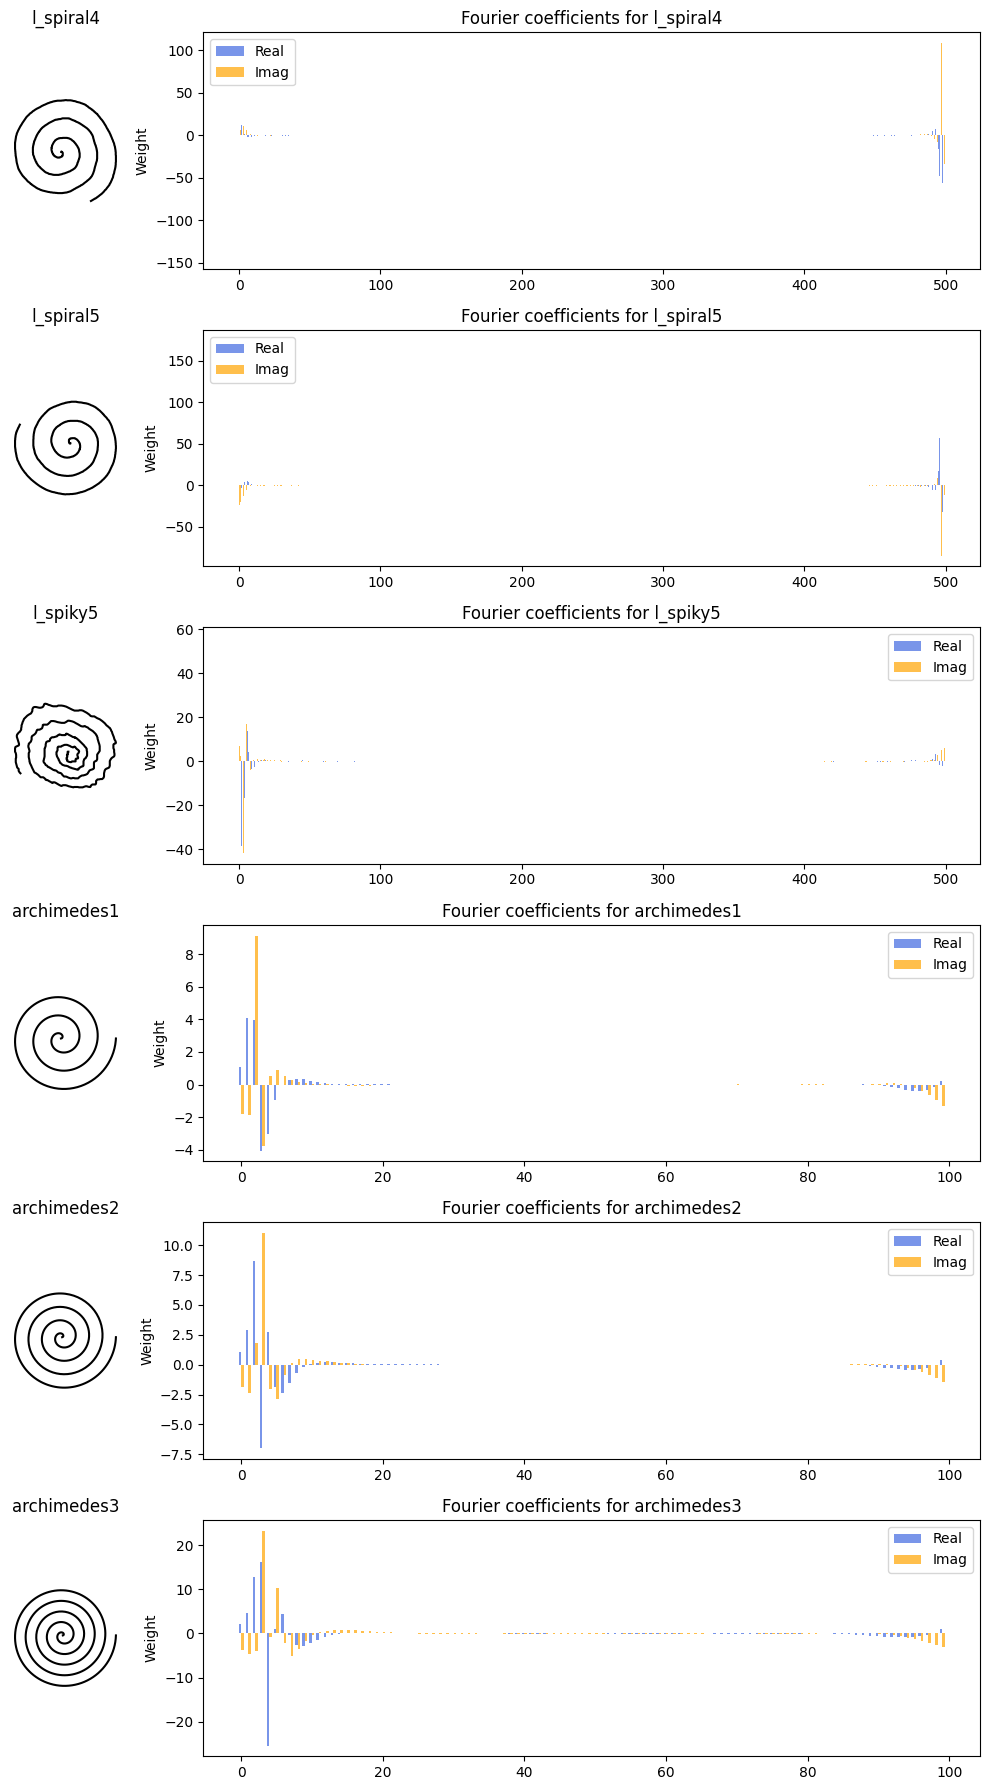

In [39]:
file_path1 = "drawings/long/l_spiral4.csv"
file_path2 = "drawings/long/l_spiral5.csv"
file_path3 = "drawings/long/l_spiky5.csv"

arch_params = [
    ([0, 6*np.pi], 1),
    ([0, 8*np.pi], 1),
    ([0, 10*np.pi], 2)
]

plot_spirals_with_coeffs(
    [file_path1, file_path2, file_path3],
    arch_params,
    M=500,
    rot_inv=False
)

### Tackling spiral's openess

In [92]:
def make_symmetric_curve(x, y, M):
    """Return a mirrored version of the curve (forward + backward)."""
    
    x_mirror = x[::-1]
    y_mirror = y[::-1]
    
    x_sym = np.concatenate((x, x_mirror))
    y_sym = np.concatenate((y, y_mirror))
    
    g_sym = resample_trajectory(list(zip(x_sym, y_sym)), M)
    
    return g_sym

In [98]:
directory = "drawings/nice_samples/"
filepath = directory + "spirala_tight.csv"
df_spiral = pd.read_csv(filepath)
df_spiral.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
df_spiral['x'] = df_spiral['x'] - df_spiral['x'].iloc[0]
df_spiral['y'] = df_spiral['y'] - df_spiral['y'].iloc[0]

M = 1000 # Number of points to resample to
g_sym = make_symmetric_curve(df_spiral['x'], df_spiral['y'], M)

In [99]:
g_sym

{0: (np.int64(0), np.int64(0)),
 1: (np.float64(0.0), np.float64(-1.3436654473333687)),
 2: (np.float64(0.0), np.float64(-2.6873308946667374)),
 3: (np.float64(-0.03099634200010648), np.float64(-4.0)),
 4: (np.float64(-1.2649258918891857), np.float64(-4.2649258918891855)),
 5: (np.float64(-2.304113674293748), np.float64(-5.0)),
 6: (np.float64(-3.6477791216271163), np.float64(-5.0)),
 7: (np.float64(-4.701057177882531), np.float64(-4.298942822117469)),
 8: (np.float64(-5.651172127338011), np.float64(-3.3488278726619884)),
 9: (np.float64(-6.0), np.float64(-2.1496516611189715)),
 10: (np.float64(-7.0), np.float64(-1.8059862137856033)),
 11: (np.float64(-7.0), np.float64(-0.4623207664522351)),
 12: (np.float64(-7.0), np.float64(0.8813446808811349)),
 13: (np.float64(-7.0), np.float64(2.225010128214503)),
 14: (np.float64(-7.402114355765063), np.float64(3.402114355765063)),
 15: (np.float64(-8.0), np.float64(4.498127460508144)),
 16: (np.float64(-8.0), np.float64(5.841792907841512)),
 17:

In [100]:
Z = fourier_descriptor_transform(g_sym)
g_reconst_sym = inverse_fourier_descriptor_transform(Z)

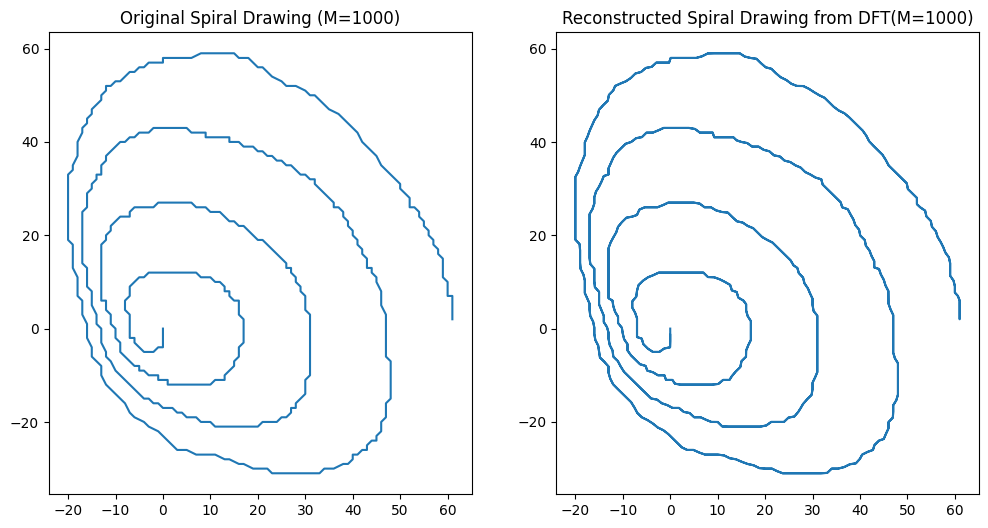

In [104]:
# df_spiral = pd.read_csv(filepath)
# df_spiral.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
# df_spiral['x'] = df_spiral['x'] - df_spiral['x'].iloc[0]
# df_spiral['y'] = df_spiral['y'] - df_spiral['y'].iloc[0]

# M = 1000 # Number of points to resample to
# g_sym = make_symmetric_curve(df_spiral['x'], df_spiral['y'], M)
# Z_sym = fourier_descriptor_transform(g_sym)
# g_reconst_sym = inverse_fourier_descriptor_transform(Z_sym)

ax, fig = plt.subplots(1, 2, figsize=(12,6))
fig[0].set_title(f'Original Spiral Drawing (M={M})')
fig[0].plot(df_spiral['x'], df_spiral['y'])
fig[1].set_title(f'Reconstructed Spiral Drawing from DFT(M={M})')
fig[1].plot(*zip(*g_reconst_sym.values()))
plt.show()